In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
import netCDF4 as nc
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
import rasotools
# from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua4 as eua
# eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

from inspect import getmembers, isfunction


from IPython.display import Image
from IPython.core.display import HTML 
import rasotools


import ray
ray.init(num_cpus=25)

no config found


2024-03-06 13:11:51,175	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-06 13:11:53,872	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.8.0


In [2]:
trends = pickle.load( open( glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_trends/*.p')[-1], "rb" ) )
trends
for i in trends.keys():
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float( i.split('_')[0]))#trends[i].lat))
            lons.append(float( i.split('_')[1]))#trends[i].lon))
            vals.append(float(trends[i].values))

trends

IndexError: list index out of range

In [12]:
np.max(lons)

181.25

In [3]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)



# x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
# gauss=x/6+y/6
# clist=numpy.linspace(-1,1,26)
# plt.contourf(x,y,gauss,clist,cmap=cmnew)
# plt.colorbar()
# plt.show()
# print('ready')

def plt_trends(lla,pdict,var='_',bias='_', marker_size = 510, marker_shape = 's', alpha=0.8, cold_positive=False):


    rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
    "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
    "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
    "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
    "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
    "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
    "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
    "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
    "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]

    if cold_positive:
        rgblist = np.flip(rgblist)
    rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

    cmnew=make_colormap(rgblist2)

    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    if 'scale' not in pdict.keys():
        pdict['scale']=2.0
    a = rasotools.plot._helpers.cost(lla[2],lla[1],lla[0])
    cost = np.sum(a)/len(a)

    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
                c= lla[0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                marker = marker_shape,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title('Brightness Temperature ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
#     plt.savefig('plots_new/cuon_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop'])+'_'+str(pdict['pl']), bbox_inches='tight')
    plt.show()
    plt.close()



pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 8]

def plot_world_map(file, mission_channel, marker_size = 510, marker_shape = 's', alpha = 0.8, cold_positive=False):
    trends = pickle.load( open( file, "rb" ) )
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float( i.split('_')[0]))#trends[i].lat))
            lons.append(float( i.split('_')[1]))#trends[i].lon))
            vals.append(float(trends[i].values))
    # print(' --- dropped ---')
    # print(maxl)
    # print(minl)
    # /10. for K/10a
    plt_trends(np.array([np.array(vals)/10., np.array(lats), np.array(lons)]), dict(var='temperature',pl=mission_channel,start='1999',stop='2009',units=r'K/10a'), marker_size = marker_size, marker_shape = marker_shape, alpha=alpha, cold_positive=cold_positive)
#     rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(vals), vmin=-5, vmax=5)
    plt.show()
    plt.close()

In [12]:
# ### Convert fiduc. data to gridded mean without interpolation
# for yr in range(2012,2018):
#     lats = np.array(range(-8875,+9125, 250))/100.
#     print(len(lats), lats)
#     lons = np.array(range(125, 36000, 250))/100.
#     print(len(lons), lons)

#     time_series = {}
#     for targetlon in lats:
#         for targetlat in lons:
#             time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[],[]]

#     for imon in range(1,13):
#         print("Month: ", imon)
#         fidu_files = glob.glob('/users/staff/uvoggenberger/scratch/fiduceo/dap.ceda.ac.uk/neodc/fiduceo/data/fcdr/microwave/v4.1/mhs/noaa19/'+str(yr)+'/'+str(imon).zfill(2)+'/*/*.0.1.nc')

#         to_concat = []
#         for fifi in fidu_files[:]:
#             # print(fifi)
#             with h5py.File(fifi) as fi:
#                 # print(fi.keys())
#                 vars = ['Ch3_BT', 'Ch4_BT', 'Ch5_BT', 'latitude', 'longitude', 'Time']
#                 to_df = {}
#                 for var in vars:
#                     if var == 'Time':
#                         to_df[var] = np.array([fi[var][:]]*90).flatten()
#                     else:
#                         to_df[var] = np.array(fi[var][:]).flatten()/100.
#                     # print(var, len(to_df[var]))
#             df = pd.DataFrame.from_dict(to_df)
#     #         break
#     #     break
#     # break
#             for chan in ['Ch3_BT', 'Ch4_BT', 'Ch5_BT']:
#                 df[chan].replace(655.35, np.nan, inplace=True)
#             df.dropna(inplace=True)
#             df.Time = pd.to_datetime(df.Time, unit='s')
#             to_concat.append(df)

#         df_mon = pd.concat(to_concat)

#         for targetlon in lats:
#             for targetlat in lons:
#                 lat_range = [targetlat - 1.25, targetlat + 1.25]
#                 lon_range = [targetlon - 1.25, targetlon + 1.25]
#                 target_df = df_mon[np.logical_and(np.logical_and(df_mon.latitude >= lat_range[0], df_mon.latitude < lat_range[1]),np.logical_and(df_mon.longitude >= lon_range[0], df_mon.longitude < lon_range[1]))]
#                 time_series[str(targetlat) + '_' + str(targetlon)][0].append(np.nanmean(target_df['Ch3_BT']))
#                 time_series[str(targetlat) + '_' + str(targetlon)][1].append(np.nanmean(target_df['Ch4_BT']))
#                 time_series[str(targetlat) + '_' + str(targetlon)][2].append(np.nanmean(target_df['Ch5_BT']))
#                 time_series[str(targetlat) + '_' + str(targetlon)][3].append(len(target_df['Ch3_BT']))
#                 time_series[str(targetlat) + '_' + str(targetlon)][4].append(str(df_mon.iloc[0].Time.year) + '-' + str(df_mon.iloc[0].Time.month))

#     pickle.dump( time_series, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fiduc_data_"+str(yr)+".p", "wb" ) )

In [13]:
time_series = pickle.load( open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fiduc_data_2010.p", "rb" ) )

for yr in range(2011,2018):
    time_series_add = pickle.load( open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fiduc_data_"+str(yr)+".p", "rb" ) )

    for k in time_series.keys():
        for i in range(5):
            time_series[k][i].extend(time_series_add[k][i])

lats = np.array(range(-8875,+9125, 250))/100.
lons = np.array(range(125, 36000, 250))/100.

trends_ch3 = {}
trends_ch4 = {}
trends_ch5 = {}
for lat_lon in time_series.keys():
    if np.count_nonzero(np.invert(np.isnan(time_series[lat_lon][0]))) < 60: # select the number of minimum available months
        continue
    df = pandas.DataFrame(np.transpose(
        [np.array(time_series[lat_lon][0]).flatten(), 
         np.array(time_series[lat_lon][1]).flatten(), 
         np.array(time_series[lat_lon][2]).flatten(), 
         np.array(time_series[lat_lon][4]).flatten(), 
         [float(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
         [float(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
         ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
    df.time = pd.to_datetime(df.time) # [pd.to_datetime('2007-01-01') + pd.Timedelta(x, 'd') for x in df.time]
    # df.replace(-99.99, np.nan, inplace=True)
    # filter_array = np.abs(df.ch3 - df.ch4) < 0.5
    # df.ch3[filter_array] = np.nan
    # df.ch4[filter_array] = np.nan
    # df.ch5[filter_array] = np.nan
    for i in df:
        if i != 'time':
            df[i] =  df[i].astype(float)
    df = df.dropna()
    if len(df) < 10:
        print('skipped: ', lat_lon)
        continue


    xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
    trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)
    trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)
    trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)

pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fidu_trends/fidu_ch3.p", "wb" ) )
pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fidu_trends/fidu_ch4.p", "wb" ) )
pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/fidu_trends/fidu_ch5.p", "wb" ) )

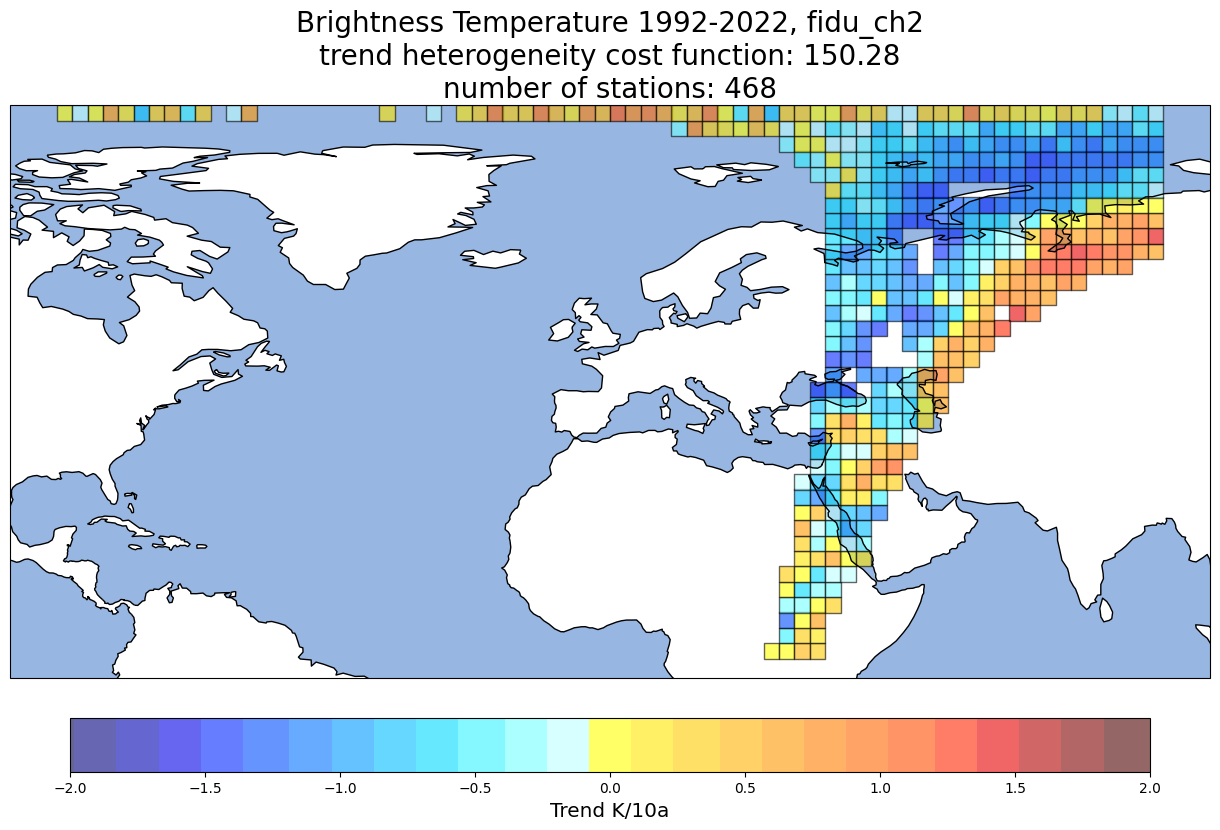

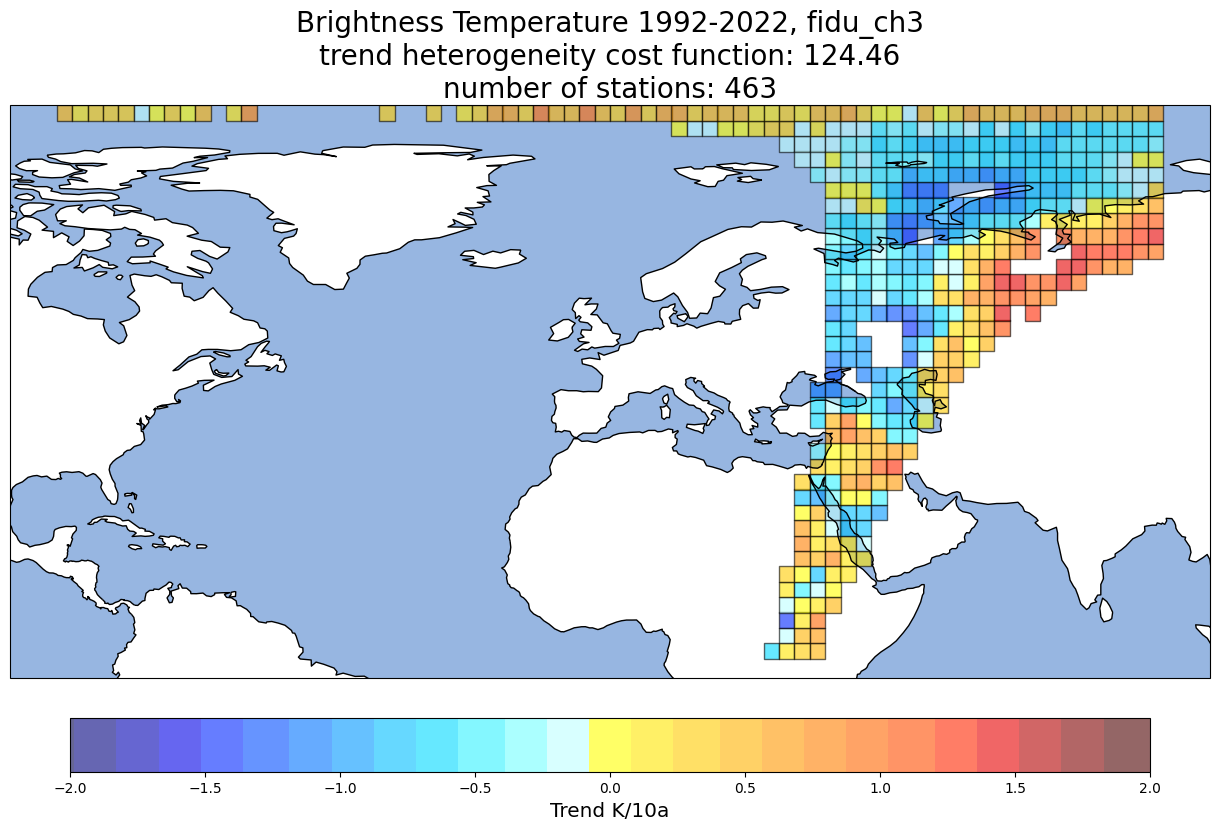

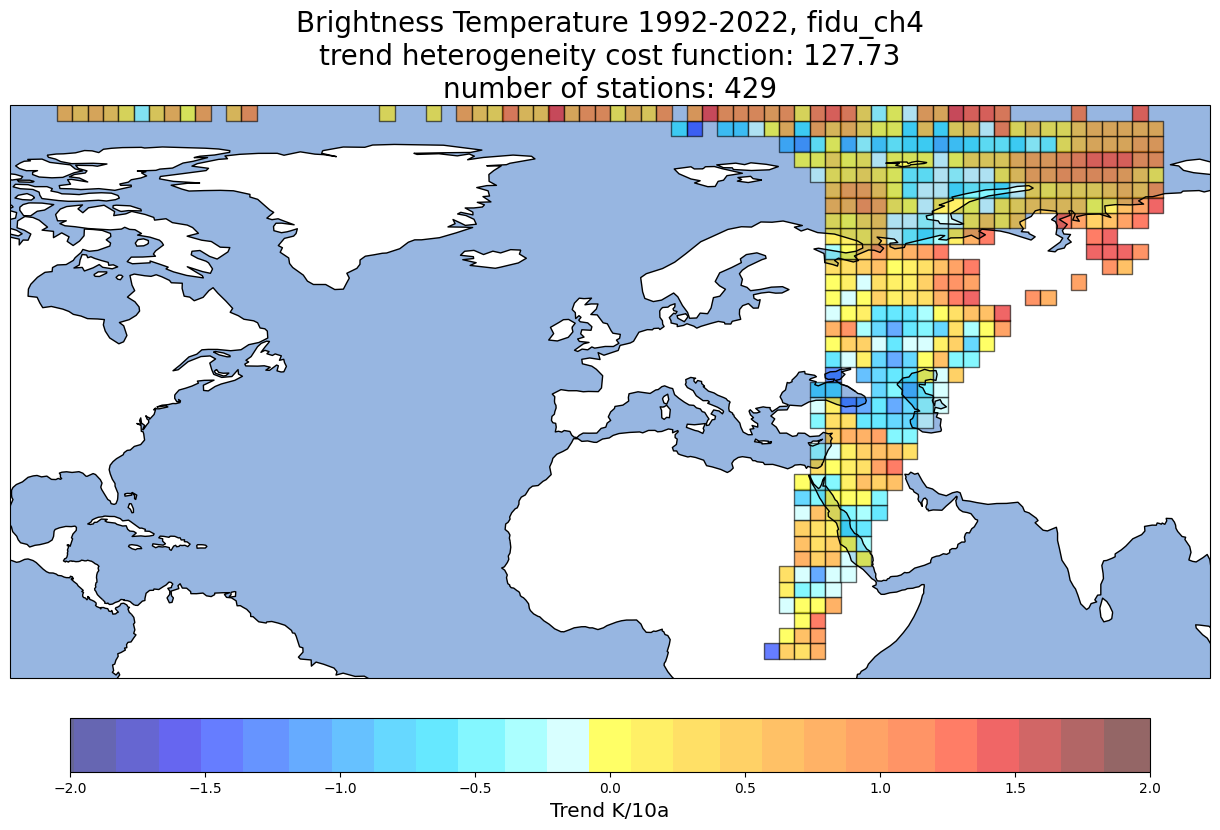

In [14]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/fidu_trends/*'+k+'.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 125, marker_shape = 's', alpha = 0.6 )


## AMSU-b

In [4]:
# ### Convert amsub. data to gridded mean without interpolation

# @ray.remote
# def calc(df_mon, lat_range, lon_range, targetlat, targetlon):
#     target_df = df_mon[np.logical_and(np.logical_and(df_mon.latitude >= lat_range[0], df_mon.latitude < lat_range[1]),np.logical_and(df_mon.longitude >= lon_range[0], df_mon.longitude < lon_range[1]))]
#     r00 = np.nanmean(target_df['Ch18_BT'])
#     r01 = np.nanmean(target_df['Ch19_BT'])
#     r02 = np.nanmean(target_df['Ch20_BT'])
#     r03 = len(target_df['Ch18_BT'])
#     r04 = str(df_mon.iloc[0].Time.year) + '-' + str(df_mon.iloc[0].Time.month)
#     return r00, r01, r02, r03, r04, targetlat, targetlon


# for yr in range(1999,2012):
#     lats = np.array(range(-8875,+9125, 250))/100.
#     print(len(lats), lats)
#     lons = np.array(range(125, 36000, 250))/100.
#     print(len(lons), lons)

#     time_series = {}
#     for targetlon in lats:
#         for targetlat in lons:
#             time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[],[]]

#     for imon in range(1,13):
#         print("Month: ", imon)
#         fidu_files = glob.glob('/users/staff/uvoggenberger/scratch/fiduceo/dap.ceda.ac.uk/neodc/fiduceo/data/fcdr/microwave/v4.1/amsub/noaa15/'+str(yr)+'/'+str(imon).zfill(2)+'/*/*.0.1.nc')

#         to_concat = []
#         for fifi in fidu_files[:]:
#             # print(fifi)
#             with h5py.File(fifi) as fi:
#                 # print(fi.keys())
#                 vars = ['Ch18_BT', 'Ch19_BT', 'Ch20_BT', 'latitude', 'longitude', 'Time']
#                 to_df = {}
#                 for var in vars:
#                     if var == 'Time':
#                         to_df[var] = np.array([fi[var][:]]*90).flatten()
#                     else:
#                         to_df[var] = np.array(fi[var][:]).flatten()/100.
#                     # print(var, len(to_df[var]))
#             df = pd.DataFrame.from_dict(to_df)
#     #         break
#     #     break
#     # break
#             for chan in ['Ch18_BT', 'Ch19_BT', 'Ch20_BT']:
#                 df[chan].replace(655.35, np.nan, inplace=True)
#             df.dropna(inplace=True)
#             df.Time = pd.to_datetime(df.Time, unit='s')
#             to_concat.append(df)

#         df_mon = pd.concat(to_concat)
#         ray_df_mon = ray.put(df_mon)
#         result_ids = []
#         for targetlon in lats[:5]:
#             for targetlat in lons[:5]:
#                 lat_range = [targetlat - 1.25, targetlat + 1.25]
#                 lon_range = [targetlon - 1.25, targetlon + 1.25]
#                 result_ids.append(calc.remote(ray_df_mon, lat_range, lon_range, targetlat, targetlon))
#         results = ray.get(result_ids)
#         print()
#         for ri in results:
#             targetlat = ri[-2]
#             targetlon = ri[-1]
#             time_series[str(targetlat) + '_' + str(targetlon)][0].append(ri[0])
#             time_series[str(targetlat) + '_' + str(targetlon)][1].append(ri[1])
#             time_series[str(targetlat) + '_' + str(targetlon)][2].append(ri[2])
#             time_series[str(targetlat) + '_' + str(targetlon)][3].append(ri[3])
#             time_series[str(targetlat) + '_' + str(targetlon)][4].append(ri[4])
    
#     pickle.dump( time_series, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/amsub_data_"+str(yr)+".p", "wb" ) )

# ray.shutdown()

In [16]:
    lats = np.array(range(-8875,+9125, 250))/100.
    print(len(lats), lats)
    lons = np.array(range(-17875, 18125, 250))/100.
    print(len(lons), lons)

72 [-88.75 -86.25 -83.75 -81.25 -78.75 -76.25 -73.75 -71.25 -68.75 -66.25
 -63.75 -61.25 -58.75 -56.25 -53.75 -51.25 -48.75 -46.25 -43.75 -41.25
 -38.75 -36.25 -33.75 -31.25 -28.75 -26.25 -23.75 -21.25 -18.75 -16.25
 -13.75 -11.25  -8.75  -6.25  -3.75  -1.25   1.25   3.75   6.25   8.75
  11.25  13.75  16.25  18.75  21.25  23.75  26.25  28.75  31.25  33.75
  36.25  38.75  41.25  43.75  46.25  48.75  51.25  53.75  56.25  58.75
  61.25  63.75  66.25  68.75  71.25  73.75  76.25  78.75  81.25  83.75
  86.25  88.75]
144 [-178.75 -176.25 -173.75 -171.25 -168.75 -166.25 -163.75 -161.25 -158.75
 -156.25 -153.75 -151.25 -148.75 -146.25 -143.75 -141.25 -138.75 -136.25
 -133.75 -131.25 -128.75 -126.25 -123.75 -121.25 -118.75 -116.25 -113.75
 -111.25 -108.75 -106.25 -103.75 -101.25  -98.75  -96.25  -93.75  -91.25
  -88.75  -86.25  -83.75  -81.25  -78.75  -76.25  -73.75  -71.25  -68.75
  -66.25  -63.75  -61.25  -58.75  -56.25  -53.75  -51.25  -48.75  -46.25
  -43.75  -41.25  -38.75  -36.25  -33.75  

In [9]:
time_series = pickle.load( open( "/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_data_1999.p", "rb" ) )

for yr in range(2000,2004):
    time_series_add = pickle.load( open( "/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_data_"+str(yr)+".p", "rb" ) )

    for k in time_series.keys():
        for i in range(5):
            time_series[k][i].extend(time_series_add[k][i])

lats = np.array(range(-8875,+9125, 250))/100.
lons = np.array(range(125, 36000, 250))/100.

trends_ch3 = {}
trends_ch4 = {}
trends_ch5 = {}
for lat_lon in time_series.keys():
    if np.count_nonzero(np.invert(np.isnan(time_series[lat_lon][0]))) < 48: # select the number of minimum available months
        continue
    df = pandas.DataFrame(np.transpose(
        [np.array(time_series[lat_lon][0]).flatten(), 
         np.array(time_series[lat_lon][1]).flatten(), 
         np.array(time_series[lat_lon][2]).flatten(), 
         np.array(time_series[lat_lon][4]).flatten(), 
         [float(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
         [float(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
         ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
    df.time = pd.to_datetime(df.time) # [pd.to_datetime('2007-01-01') + pd.Timedelta(x, 'd') for x in df.time]
    # df.replace(-99.99, np.nan, inplace=True)
    # filter_array = np.abs(df.ch3 - df.ch4) < 0.5
    # df.ch3[filter_array] = np.nan
    # df.ch4[filter_array] = np.nan
    # df.ch5[filter_array] = np.nan
    for i in df:
        if i != 'time':
            df[i] =  df[i].astype(float)
    df = df.dropna()
    if len(df) < 10:
        print('skipped: ', lat_lon)
        continue


    xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
    trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)
    trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)
    trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5, only_slopes=True, method='polyfit')* 3650) # len(df.time)*12.*10.)

pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_trends/amsub_ch3.p", "wb" ) )
pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_trends/amsub_ch4.p", "wb" ) )
pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_trends/amsub_ch5.p", "wb" ) )

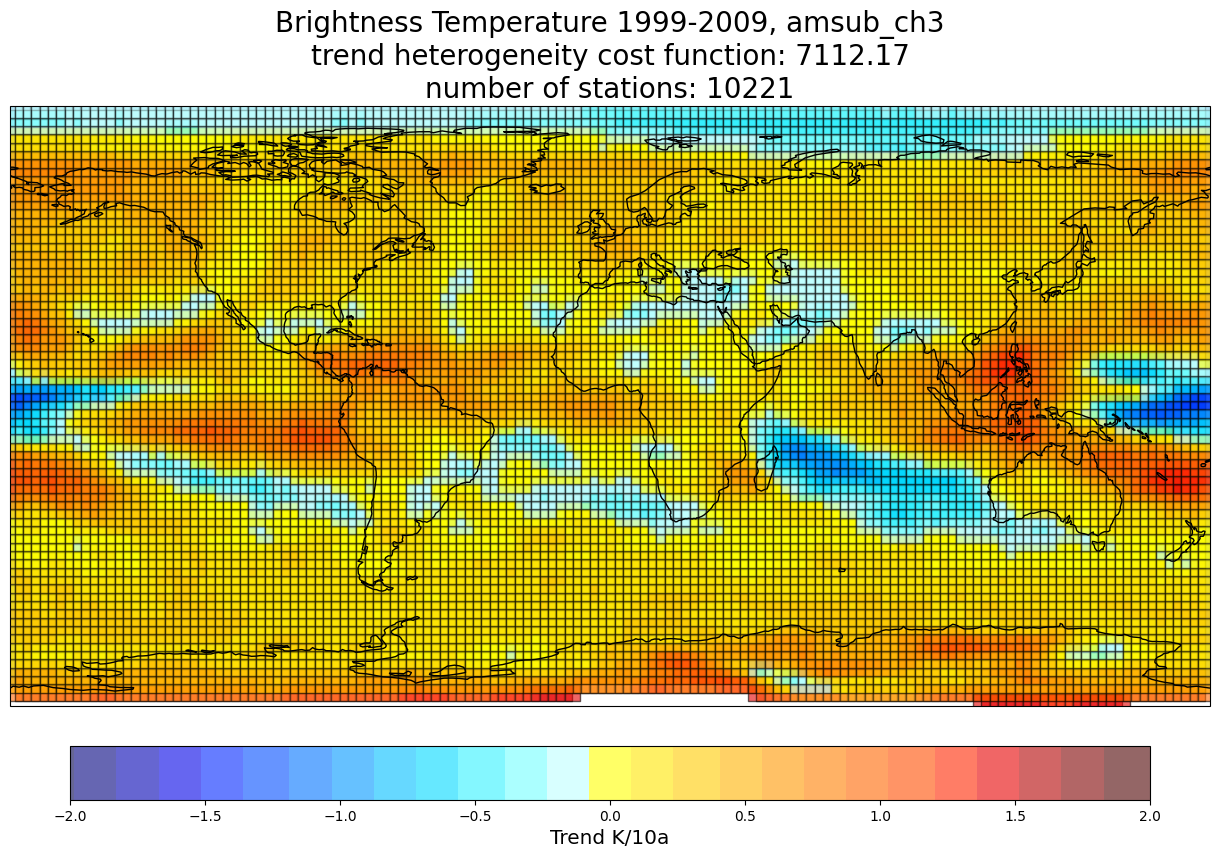

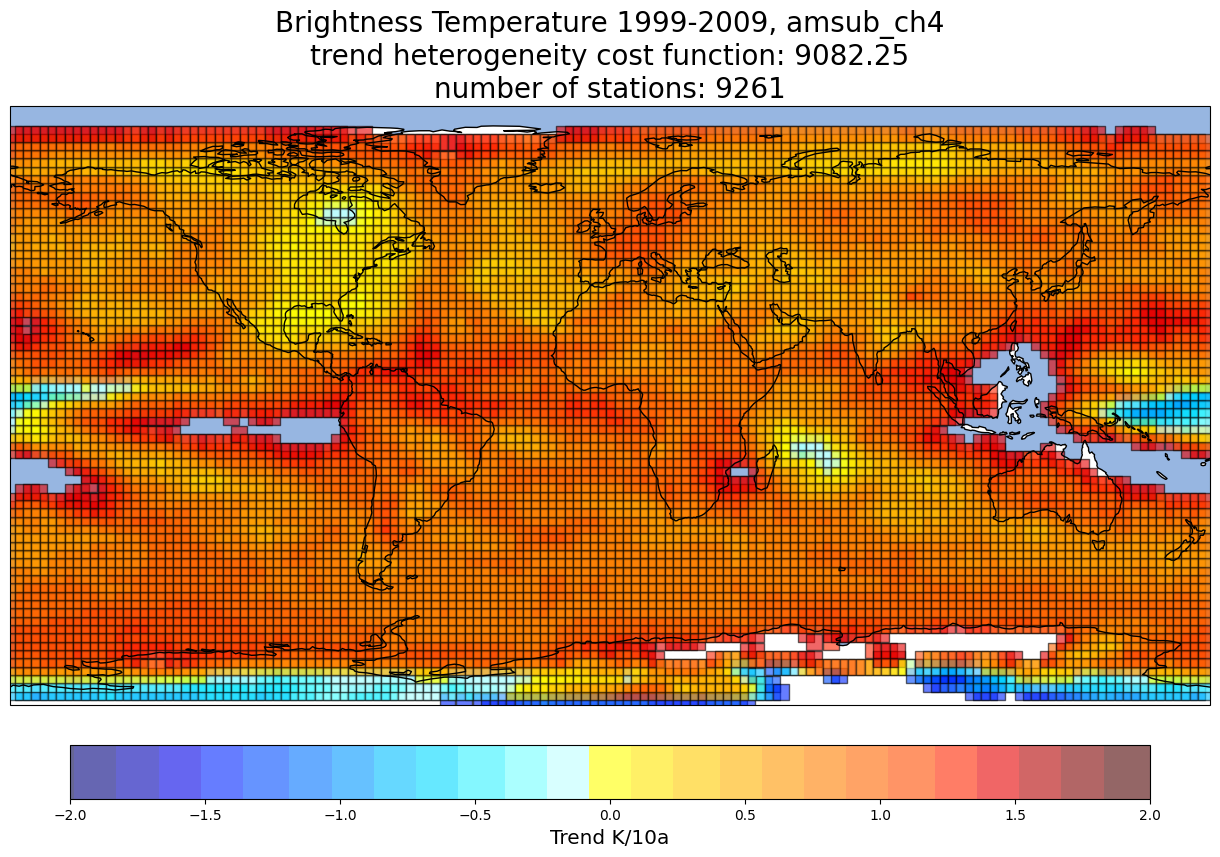

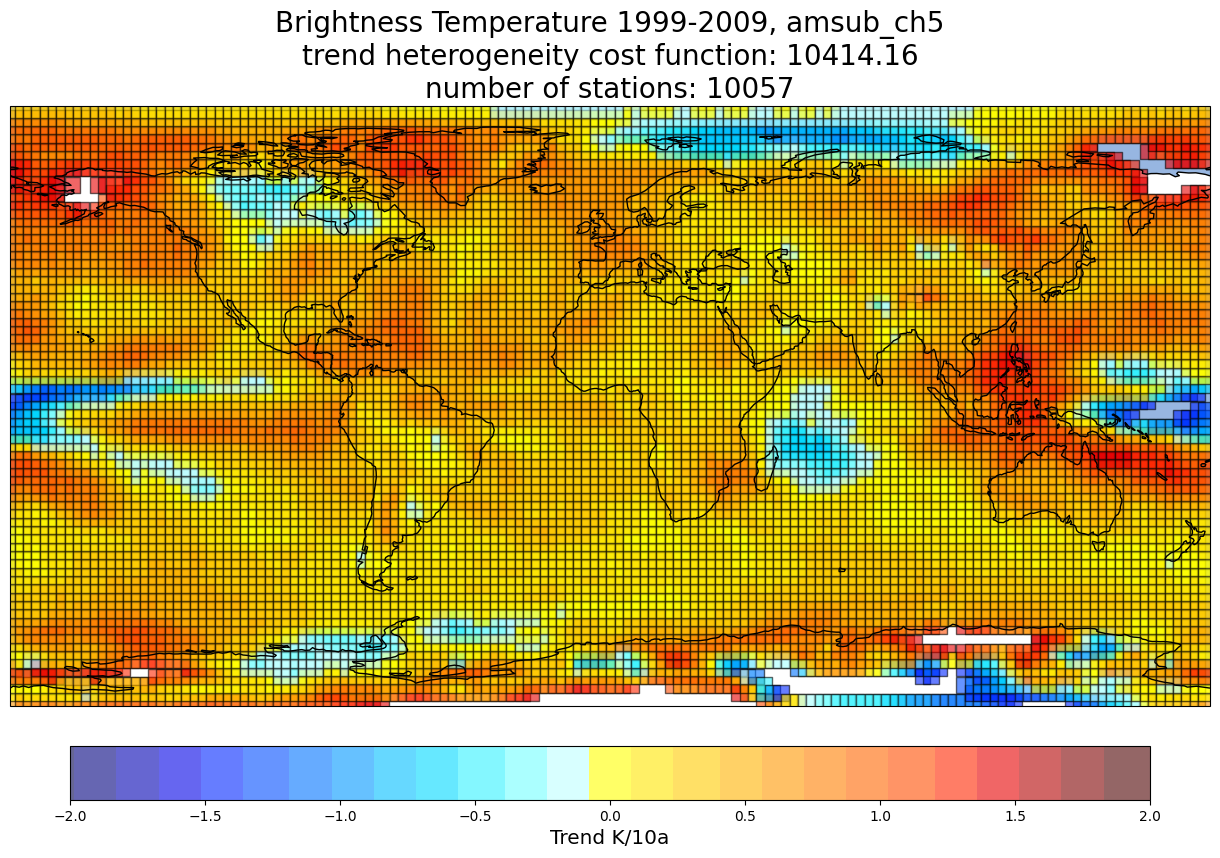

In [13]:
for k in ['ch3', 'ch4', 'ch5']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/new2_amsub_trends/*'+k+'.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 125, marker_shape = 's', alpha = 0.6, cold_positive=False)
